# EDA

## Library Import

In [61]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, precision_score,
                             recall_score, f1_score, classification_report, 
                             ConfusionMatrixDisplay)

from sklearn import set_config
set_config(transform_output="pandas")

from category_encoders import HashingEncoder

import sqlite3

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, ConfusionMatrixDisplay

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay


In [62]:
def eval_classification(model, X_train, y_train, X_test, y_test, model_name="model", results_frame=None,
                        pos_label=1, average="binary", roc_auc_average="macro"):
    
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    print("Train Evaluation")
    print(classification_report(y_train, train_pred))
    ConfusionMatrixDisplay.from_predictions(y_train, train_pred, normalize="true", cmap="Blues")
    plt.show()

    print("Test Evaluation")
    print(classification_report(y_test, test_pred))
    ConfusionMatrixDisplay.from_predictions(y_test, test_pred, normalize="true", cmap="Greens")
    plt.show()

    results = pd.DataFrame(index=[model_name])
  
    results["train_acc"] = accuracy_score(y_train, train_pred)
    results["test_acc"] = accuracy_score(y_test, test_pred)
    results["train_prec"] = precision_score(y_train, train_pred, pos_label=pos_label, average=average)
    results["test_prec"] = precision_score(y_test, test_pred, pos_label=pos_label, average=average)
    results["train_recall"] = recall_score(y_train, train_pred, pos_label=pos_label, average=average)
    results["test_recall"] = recall_score(y_test, test_pred, pos_label=pos_label, average=average)
    results["train_f1"] = f1_score(y_train, train_pred, pos_label=pos_label, average=average)
    results["test_f1"] = f1_score(y_test, test_pred, pos_label=pos_label, average=average)
    results["train_auc"] = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1], multi_class="ovr", average=roc_auc_average)
    results["test_auc"] = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1], multi_class="ovr", average=roc_auc_average)  


    if results_frame is not None:
        results = pd.concat([results_frame, results])

    return results

In [70]:
local_prepend = "../.."
input_path = "/kaggle/input/home-credit-default-risk/"
# kaggle_notebook_input_path = "/kaggle/input/home-credit-default-risk/"

# con = sqlite3.connect(local_prepend + input_path + "home-credit-default-risk.sqlite") # connect to database
# pd.read_csv(local_prepend + input_path + "application_train.csv").to_sql("application_train", con, if_exists='append', index=False, index_label="SK_ID_CURR")

application_train = pd.read_csv(local_prepend + input_path + "application_train.csv")

# bureau_balance = pd.read_csv(local_prepend + input_path + "bureau_balance.csv")
bureau = pd.read_csv(local_prepend + input_path + "bureau.csv")
credit_card_balance = pd.read_csv(local_prepend + input_path + "credit_card_balance.csv")
# installments_payments = pd.read_csv(local_prepend + input_path + "installments_payments.csv")
POS_CASH_balance = pd.read_csv(local_prepend + input_path + "POS_CASH_balance.csv")
previous_application = pd.read_csv(local_prepend + input_path + "previous_application.csv")

# Description of columns in provided datasets
# HomeCredit_columns_description = pd.read_csv(local_prepend + input_path + "HomeCredit_columns_description.csv", encoding = "latin")

# # Test Data for later use
# application_test = pd.read_csv(local_prepend + input_path + "application_test.csv")

In [64]:

# dfs_to_merge = [bureau, previous_application, POS_CASH_balance, credit_card_balance]

# for df in dfs_to_merge:
#     application_train = pd.merge(application_train, df, how="inner", on="SK_ID_CURR")

# application_train.shape

In [71]:
application_train = pd.merge(application_train, bureau, how="left", on="SK_ID_CURR")


In [72]:
application_train = application_train.drop_duplicates(subset=["SK_ID_CURR"])

In [73]:
application_train = pd.merge(application_train, previous_application, how="left", on="SK_ID_CURR")


In [74]:
application_train = application_train.drop_duplicates(subset=["SK_ID_CURR"])

In [75]:
application_train = pd.merge(application_train, POS_CASH_balance, how="left", on="SK_ID_CURR")

In [76]:
application_train = application_train.drop_duplicates(subset=["SK_ID_CURR"])

In [77]:
application_train = pd.merge(application_train, credit_card_balance, how="left", on="SK_ID_CURR")

In [79]:
application_train = application_train.drop_duplicates(subset=["SK_ID_CURR"])

In [78]:
application_train.select_dtypes(include='object')

,NAME_CONTRACT_TYPE_x,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE_x,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,...,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,NAME_SELLER_INDUSTRY,NAME_YIELD_GROUP,PRODUCT_COMBINATION,NAME_CONTRACT_STATUS_y,NAME_CONTRACT_STATUS
0,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,...,New,Vehicles,POS,XNA,Stone,Auto technology,low_normal,POS other with interest,Active,NaN
1,Cash loans,F,N,N,Family,State servant,Higher education,Married,House / apartment,Core staff,...,Repeater,XNA,Cash,x-sell,Credit and cash offices,XNA,low_normal,Cash X-Sell: low,Active,NaN
2,Revolving loans,M,Y,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,...,New,Mobile,POS,XNA,Regional / Local,Connectivity,middle,POS mobile without interest,Active,NaN
3,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Laborers,...,Repeater,XNA,Cash,x-sell,Credit and cash offices,XNA,low_normal,Cash X-Sell: low,Active,Active
4,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Laborers,...,Repeater,XNA,Cash,x-sell,Credit and cash offices,XNA,low_normal,Cash X-Sell: low,Active,Active
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3448566,Cash loans,M,N,N,Unaccompanied,Working,Secondary / secondary special,Separated,With parents,Sales staff,...,New,Mobile,POS,XNA,Country-wide,Connectivity,high,POS mobile with interest,Signed,NaN
3448567,Cash loans,F,N,Y,Unaccompanied,Pensioner,Secondary / secondary special,Widow,House / apartment,NaN,...,New,Consumer Electronics,POS,XNA,Country-wide,Consumer electronics,low_normal,POS household without interest,Completed,NaN
3448568,Cash loans,F,N,Y,Unaccompanied,Working,Higher education,Separated,House / apartment,Managers,...,Refreshed,Mobile,POS,XNA,Stone,Connectivity,high,POS mobile with interest,Active,NaN
3448569,Cash loans,F,N,Y,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,Laborers,...,Repeater,Computers,POS,XNA,Country-wide,Consumer electronics,low_normal,POS household with interest,Active,NaN


In [11]:
object_cols = application_train.select_dtypes(include='object').columns.to_list()

for col in object_cols:
    print(application_train[col].value_counts())

NAME_CONTRACT_TYPE_x
Cash loans         7278817
Revolving loans     575814
Name: count, dtype: int64
CODE_GENDER
F      5499851
M      2354325
XNA        455
Name: count, dtype: int64
FLAG_OWN_CAR
N    5059651
Y    2794980
Name: count, dtype: int64
FLAG_OWN_REALTY
Y    5723112
N    2131519
Name: count, dtype: int64
NAME_TYPE_SUITE_x
Unaccompanied      6524439
Family              969606
Spouse, partner     222243
Children             70699
Other_B              31210
Other_A              12886
Group of people       6012
Name: count, dtype: int64
NAME_INCOME_TYPE
Working                 3980915
Commercial associate    1769912
Pensioner               1485701
State servant            618032
Student                      69
Unemployed                    2
Name: count, dtype: int64
NAME_EDUCATION_TYPE
Secondary / secondary special    5584792
Higher education                 1954568
Incomplete higher                 236981
Lower secondary                    74608
Academic degree                

In [80]:
df_num = application_train.select_dtypes(include='number')
df_num

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,AMT_GOODS_PRICE_x,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD_y,SK_DPD_DEF_y
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,...,0.0,0.0,0.0,NaN,0.0,NaN,NaN,0.0,0.0,0.0
9,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3448566,456251,0,0,157500.0,254700.0,27558.0,225000.0,0.032561,-9327,-236,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3448567,456252,0,0,72000.0,269550.0,12001.5,225000.0,0.025164,-20775,365243,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3448568,456253,0,0,153000.0,677664.0,29979.0,585000.0,0.005002,-14966,-7921,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3448569,456254,1,0,171000.0,370107.0,20205.0,319500.0,0.005313,-11961,-4786,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# df_num = df_num.dropna()
# df_num

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,AMT_GOODS_PRICE_x,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,RATE_INTEREST_PRIVILEGED,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
57379,102658,0,2,270000.0,781920.0,37746.0,675000.0,0.006305,-15665,-408,...,0.867336,-396,15,12.0,365243.0,-360.0,-30.0,-270.0,-267.0,0.0
140336,106669,1,0,135000.0,119893.5,14355.0,103500.0,0.020713,-9408,-1339,...,0.867336,-331,40,12.0,365243.0,-290.0,40.0,-170.0,-164.0,0.0
152226,107170,0,0,121500.0,225000.0,20637.0,225000.0,0.035792,-8769,-1624,...,0.715645,-504,60,12.0,365243.0,-458.0,-128.0,-368.0,-365.0,0.0
152232,107170,0,0,121500.0,225000.0,20637.0,225000.0,0.035792,-8769,-1624,...,0.715645,-504,60,12.0,365243.0,-458.0,-128.0,-368.0,-365.0,0.0
510066,123784,0,1,360000.0,286704.0,20520.0,247500.0,0.072508,-11770,-4778,...,0.852537,-103,15,12.0,365243.0,365243.0,365243.0,365243.0,365243.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7220131,427619,0,1,306000.0,720000.0,50242.5,720000.0,0.028663,-14394,-4652,...,0.715645,-391,50,12.0,365243.0,-354.0,-24.0,-294.0,-292.0,0.0
7358718,434054,0,2,139500.0,814041.0,28971.0,679500.0,0.046220,-13981,-1151,...,0.835095,-89,20,12.0,365243.0,-52.0,278.0,-22.0,-16.0,0.0
7655295,447433,0,0,270000.0,247675.5,22716.0,229500.0,0.025164,-9639,-1705,...,0.715645,-535,25,12.0,365243.0,-487.0,-157.0,-427.0,-421.0,0.0
7655303,447433,0,0,270000.0,247675.5,22716.0,229500.0,0.025164,-9639,-1705,...,0.715645,-535,25,12.0,365243.0,-487.0,-157.0,-427.0,-421.0,0.0


In [81]:
df_num = df_num.drop_duplicates(subset=["SK_ID_CURR"])
df_num

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,AMT_GOODS_PRICE_x,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD_y,SK_DPD_DEF_y
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,...,0.0,0.0,0.0,NaN,0.0,NaN,NaN,0.0,0.0,0.0
9,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3448566,456251,0,0,157500.0,254700.0,27558.0,225000.0,0.032561,-9327,-236,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3448567,456252,0,0,72000.0,269550.0,12001.5,225000.0,0.025164,-20775,365243,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3448568,456253,0,0,153000.0,677664.0,29979.0,585000.0,0.005002,-14966,-7921,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3448569,456254,1,0,171000.0,370107.0,20205.0,319500.0,0.005313,-11961,-4786,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: >

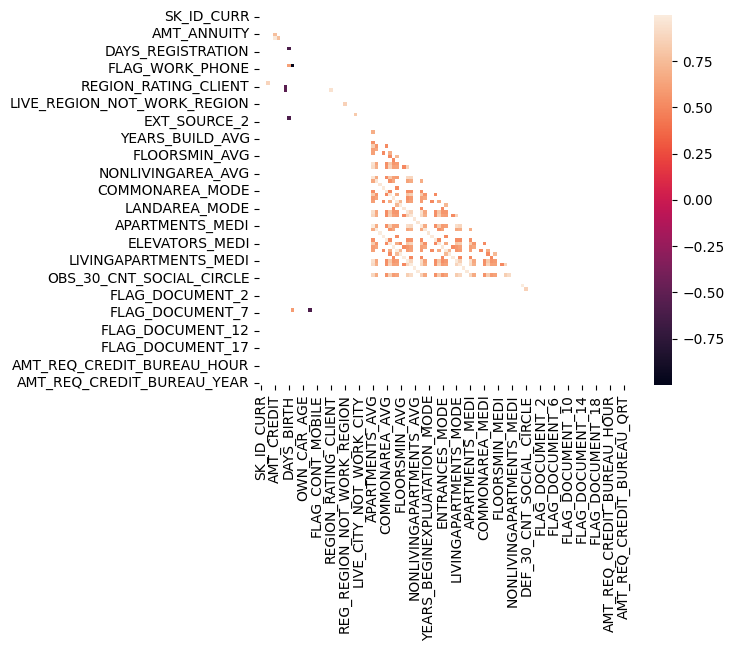

In [61]:
# Generate a mask for the upper triangle
mask = np.zeros_like(df_num.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(df_num.corr().where(lambda x: abs(x)>0.5), mask=mask, square=True)

In [82]:
# split data
X = df_num.drop(columns=["TARGET", "SK_ID_CURR"])
y = df_num["TARGET"].copy()

In [ ]:
# Training split:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

num_cols = X.columns.to_list()

# Create Transformers
zero_imputer = SimpleImputer(strategy="constant", fill_value=0)
# scaler = StandardScaler()

# Create tuples
impute_tuple = ("imputation", zero_imputer, num_cols)
# scaler_tuple = ("scaling", scaler, num_cols)


# Create ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[impute_tuple], remainder="passthrough",
    verbose_feature_names_out=True)

# Test preprocessor
preprocessor.fit(X_train)
X_train_proc = preprocessor.transform(X_train)
X_test_proc = preprocessor.transform(X_test)
X_val_proc = preprocessor.transform(X_val)

In [ ]:
logreg_balanced = LogisticRegression(max_iter=1000, class_weight="balanced")

logreg_balanced_pipe = make_pipeline(StandardScaler(), logreg_balanced)

logreg_balanced_pipe.fit(X_train_proc, y_train)

# balanced_results = eval_classification(logreg_balanced_pipe, X_train_proc, y_train, X_test_proc, y_test,
#                               model_name="Logistic Regression Balanced Class Weights")

# balanced_results

print("Train")
print(classification_report(y_train, train_pred))
print("Test")
print(classification_report(y_test, test_pred))

In [ ]:
# from sklearn.model_selection import GridSearchCV

# knn = KNeighborsClassifier()
# param_space = {'n_neighbors': range(3,8)}
# knn_gs = GridSearchCV(knn, param_space)
# knn_gs.fit(X_train_proc, y_train)
# best_knn = knn_gs.best_estimator_
# best_knn

KNeighborsClassifier(n_neighbors=6)

In [17]:
knn_pipe = Pipeline([("scaler", StandardScaler()), ("knn", best_knn)])

knn_pipe.fit(X_train_proc, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=6))])

In [ ]:
zero_imputer.fit(X)

zero_X = zero_imputer.transform(X)
knn_pipe2 = Pipeline([("scaler", StandardScaler()), 
                      ("knn", KNeighborsClassifier(n_neighbors=6))])

knn_pipe2.fit(zero_X, y) 

zero_X_cols = zero_X.columns.to_list()


In [88]:
test_data_file = "application_test.csv"
test_data = pd.read_csv(local_prepend + input_path + test_data_file)

test_data = pd.merge(test_data, bureau, how="left", on="SK_ID_CURR")
test_data = test_data.drop_duplicates(subset=["SK_ID_CURR"])
test_data = pd.merge(test_data, previous_application, how="left", on="SK_ID_CURR")
test_data = test_data.drop_duplicates(subset=["SK_ID_CURR"])
test_data = pd.merge(test_data, POS_CASH_balance, how="left", on="SK_ID_CURR")
test_data = test_data.drop_duplicates(subset=["SK_ID_CURR"])
test_data = pd.merge(test_data, credit_card_balance, how="left", on="SK_ID_CURR")
test_data = test_data.drop_duplicates(subset=["SK_ID_CURR"])

ids = test_data.pop("SK_ID_CURR")

test_data = test_data[zero_X_cols]

zero_test = zero_imputer.transform(test_data)

preds = knn_pipe2.predict_proba(zero_test)[:,1]

output = pd.DataFrame({"SK_ID_CURR": ids,
                       "TARGET": preds})

In [89]:
output

,SK_ID_CURR,TARGET
0,100001,0.166667
1,100005,0.000000
2,100013,0.000000
98,100028,0.166667
147,100038,0.500000
...,...,...
644422,456221,0.166667
644423,456222,0.000000
644424,456223,0.166667
644425,456224,0.000000


In [91]:
sample_submission_file = "sample_submission.csv"
sample_submission_df = pd.read_csv(local_prepend + input_path + sample_submission_file)
sample_submission_df["TARGET"] = preds
sample_submission_df.to_csv("00f_more_merges.csv", index=False)
sample_submission_df.head()

,SK_ID_CURR,TARGET
0,100001,0.166667
1,100005,0.000000
2,100013,0.000000
3,100028,0.166667
4,100038,0.500000


In [17]:
# # create a logistic regression
# log_reg = LogisticRegression(max_iter=100000, random_state=42)
# log_reg.fit(X_train_proc, y_train)
# log_reg.predict_proba(X_test_proc)[:,0]

Train Evaluation
              precision    recall  f1-score   support

           0       0.92      1.00      0.96    211999
           1       0.00      0.00      0.00     18634

    accuracy                           0.92    230633
   macro avg       0.46      0.50      0.48    230633
weighted avg       0.84      0.92      0.88    230633

Test Evaluation
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     70687
           1       0.00      0.00      0.00      6191

    accuracy                           0.92     76878
   macro avg       0.46      0.50      0.48     76878
weighted avg       0.85      0.92      0.88     76878



/Users/bharat/Documents/GitHub/kaggle/.conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/bharat/Documents/GitHub/kaggle/.conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/bharat/Documents/GitHub/kaggle/.conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

,train_acc,test_acc,train_prec,test_prec,train_recall,test_recall,train_f1,test_f1
best knn,0.919205,0.91947,0.0,0.0,0.0,0.0,0.0,0.0


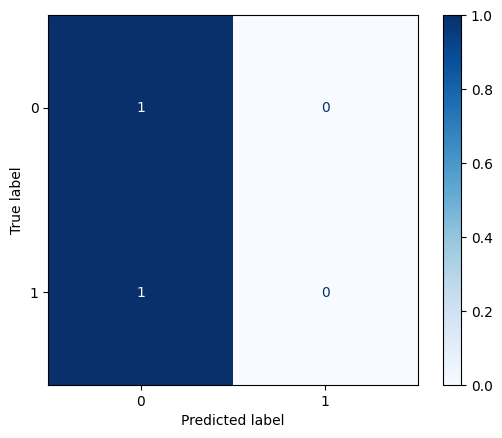

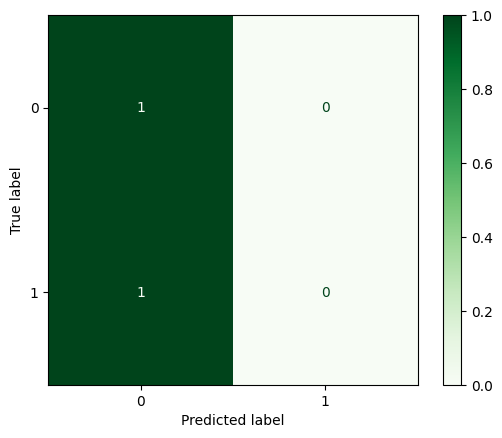

In [19]:
eval_classification(best_knn, X_train_proc, y_train, X_test_proc, y_test, model_name="best knn", results_frame=None,
                        pos_label=1, average="binary")

In [23]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline

In [22]:
y_train.value_counts()

TARGET
0    211999
1     18634
Name: count, dtype: int64